# Steroids in Sepsis - Q-learning

Adapted from [this notebook](https://github.com/VinF/practical_sessions_RL/tree/main/TD_learning_DQN) by Buelent Uendes

## Setup

### Imports

In [35]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

### Global Variables


In [75]:
# --- Data and Environment --- #
TRAIN_SPLIT = 0.6 # Training split for the data. Validation and test will be evenly split over the remainder
NUM_BINS = 3  # Number of bins to split the dosages over by evenly spaced quantiles
DEAD_XDAYS = 'dead_30days' # ['dead_90days', 'dead_30days'] -> use as target metric
END_REWARD = 100 # Magnitude of the terminal reward

# --- Hyperparameters --- #

DISCOUNT_RATE = 0.98
BATCH_SIZE = 64
BUFFER_SIZE = 50000
MIN_REPLAY_SIZE = 1000
MAX_EPISODES = 10*25000
LEARNING_RATE = 0.01 # 5e-4

### Global Constants

In [76]:
DATA_PATH = 'gdrive/My Drive/MLR4Health/processed_data.csv' # Path to the processed data
SEED = 7  # Seed for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cpu


### Seed

In [77]:
# Setting the seed for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Data

### Loading the data

In [78]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
data = pd.read_csv(DATA_PATH)
data.head(5)

,admissionid,time_bin,dose,Dexamethason,Hydrocortison,Methylprednisolon,Prednisolon,Prednisonum,heartrate,sys_BP,...,diagnosis_subgroup_Pulmonale chirurgie,diagnosis_subgroup_Renaal,diagnosis_subgroup_Transplantatie chirurgie,diagnosis_subgroup_Traumatologie,diagnosis_subgroup_Tumor chirurgie,diagnosis_subgroup_Urogenitaal,diagnosis_subgroup_Vaatchirurgie,diagnosis_subgroup_Vasculair chirurgisch,diagnosis_subgroup_Vasculair neurologisch,last_row
0,11,0.0,100.0,0.0,1.0,0.0,0.0,0.0,133.20,94.80,...,0,0,0,0,0,0,0,0,0,False
1,11,1.0,100.0,0.0,1.0,0.0,0.0,0.0,123.25,96.50,...,0,0,0,0,0,0,0,0,0,False
2,11,2.0,100.0,0.0,1.0,0.0,0.0,0.0,126.00,96.00,...,0,0,0,0,0,0,0,0,0,False
3,11,3.0,100.0,0.0,1.0,0.0,0.0,0.0,121.00,105.25,...,0,0,0,0,0,0,0,0,0,False
4,11,4.0,100.0,0.0,1.0,0.0,0.0,0.0,129.20,108.20,...,0,0,0,0,0,0,0,0,0,False


### Action binning

In [80]:
# Divide the actions based on evenly spaced quantiles of the dose
bin_labels = list(range(NUM_BINS))
bin_col, bins = pd.qcut(data['dose'], q=NUM_BINS, labels=bin_labels, retbins=True)
dose_col_idx = data.columns.get_loc("dose")
data.insert(loc=dose_col_idx+1, column='action', value=bin_col)
data.sample(5)

,admissionid,time_bin,dose,action,Dexamethason,Hydrocortison,Methylprednisolon,Prednisolon,Prednisonum,heartrate,...,diagnosis_subgroup_Pulmonale chirurgie,diagnosis_subgroup_Renaal,diagnosis_subgroup_Transplantatie chirurgie,diagnosis_subgroup_Traumatologie,diagnosis_subgroup_Tumor chirurgie,diagnosis_subgroup_Urogenitaal,diagnosis_subgroup_Vaatchirurgie,diagnosis_subgroup_Vasculair chirurgisch,diagnosis_subgroup_Vasculair neurologisch,last_row
122318,17775,44.0,25.0,0,0.0,1.0,0.0,0.0,0.0,89.500000,...,0,0,0,0,0,0,0,0,0,False
52124,7931,31.0,25.0,0,0.0,1.0,0.0,0.0,0.0,81.000000,...,0,0,0,0,0,0,0,0,0,False
23832,3784,156.0,50.0,1,0.0,1.0,0.0,0.0,0.0,84.000000,...,0,0,0,0,0,0,0,0,0,False
29645,4781,58.0,30.0,1,0.0,0.0,0.0,1.0,0.0,88.250000,...,0,0,0,0,0,0,0,0,0,False
10746,1619,28.0,10.0,0,0.0,0.0,0.0,1.0,0.0,85.333333,...,0,0,0,0,0,0,0,0,0,False


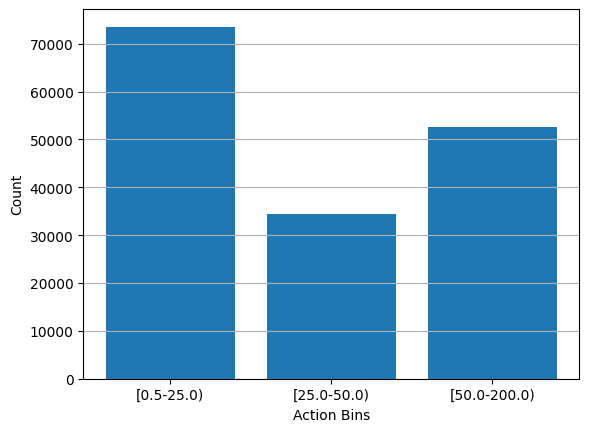

In [81]:
# Plot the distribution of actions
value_counts = data['action'].value_counts(sort=False)
bin_labels = [f"[{bins[i]}-{bins[i+1]})" for i in range(0,len(bins)-1)]

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Action Bins')
plt.ylabel('Count')
plt.xticks(ticks=value_counts.index, labels=bin_labels)
plt.grid(axis='y')
plt.show()

### Rewards

In [82]:
def add_reward(row):
  # Zero if it's not the last entry for the admission
  if not row['last_row']:
    return 0

  # If the patient died after x days -> -100
  if row[DEAD_XDAYS]:
    return -END_REWARD

  # Otherwise -> +100
  return END_REWARD

In [83]:
data['reward'] = data.apply(add_reward, axis=1)

In [84]:
data[data['last_row'] == True][[DEAD_XDAYS, 'last_row','reward']]

,dead_30days,last_row,reward
7,True,True,-100
49,False,True,100
63,True,True,-100
69,False,True,100
96,False,True,100
...,...,...,...
160598,True,True,-100
160630,True,True,-100
160634,False,True,100
160676,True,True,-100


### Defining the feature and action space

In [85]:
data.columns

Index(['admissionid', 'time_bin', 'dose', 'action', 'Dexamethason',
       'Hydrocortison', 'Methylprednisolon', 'Prednisolon', 'Prednisonum',
       'heartrate', 'sys_BP', 'mean_BP', 'dia_BP', 'saturation', 'resp_rate',
       'temp_axil', 'kreatinine', 'glucose_bloed', 'leucocyten',
       'thrombocyten', 'kalium', 'natrium_astrup', 'natrium', 'laktaat',
       'bili_totaal', 'hemoglobine', 'kalium_astrup', 'sofa_respiration_score',
       'sofa_coagulation_score', 'sofa_liver_score',
       'sofa_cardiovascular_score', 'sofa_cns_score', 'sofa_renal_score',
       'sofa_total_score', 'dayofdeath', 'dead_30days', 'dead_90days',
       'lengthofstay', 'gender_', 'gender_Man', 'gender_Vrouw',
       'agegroup_18-39', 'agegroup_40-49', 'agegroup_50-59', 'agegroup_60-69',
       'agegroup_70-79', 'agegroup_80+', 'weightgroup_100-109',
       'weightgroup_110+', 'weightgroup_59-', 'weightgroup_60-69',
       'weightgroup_70-79', 'weightgroup_80-89', 'weightgroup_90-99',
       'heightgroup

In [86]:
non_features = [
    'admissionid',
    'time_bin',
    'dose',
    'action',
    'dayofdeath',
    'dead_30days',
    'dead_90days',
    'lengthofstay',
    'last_row',
    'reward'
    ]

features = [col for col in data.columns if col not in non_features]
num_features = len(features)
print("Number of features:", num_features)

Number of features: 75


In [87]:
num_actions = data['action'].nunique()
print("Number of actions:", num_actions)

Number of actions: 3


### Train/Validation/Test split

In [88]:
unique_admission_ids = data['admissionid'].unique()

train_ids, temp_ids = train_test_split(unique_admission_ids, test_size=1-TRAIN_SPLIT, random_state=SEED)
validation_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED)

train_df = data[data['admissionid'].isin(train_ids)].reset_index(drop=True)
validation_df = data[data['admissionid'].isin(validation_ids)].reset_index(drop=True)
test_df = data[data['admissionid'].isin(test_ids)].reset_index(drop=True)

print("Train set size:", len(train_df))
print("Validation set size:", len(validation_df))
print("Test set size:", len(test_df))

Train set size: 96106
Validation set size: 31657
Test set size: 32931


## Classes

### DQN

In [89]:
class DQN(nn.Module):

    def __init__(self, num_input_features, num_out_features, learning_rate):

        '''
        Params:
        num_input_features = number of feature columns
        num_out_features = number of actions to choose from
        learning_rate = learning rate used in the update
        '''

        super(DQN,self).__init__()

        self.dense1 = nn.Linear(in_features = num_input_features, out_features = 128)
        self.dense2 = nn.Linear(in_features = 128, out_features = 64)
        self.dense3 = nn.Linear(in_features = 64, out_features = 32)
        self.dense4 = nn.Linear(in_features = 32, out_features = num_out_features)

        self.relu = nn.ReLU()
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)

    def forward(self, x):

        '''
        Params:
        x = observation (one row from the feature columns)
        '''

        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.relu(self.dense3(x))
        x = self.dense4(x)

        return x


### Experience replay

In [90]:
class ExperienceReplay:

    def __init__(self, df, buffer_size, min_replay_size = 1000):

        '''
        Params:
        df = dataframe containing processed timeseries data
        buffer_size = max number of transitions that the experience replay buffer can store
        min_replay_size = min number of transitions that the replay buffer needs to have when initialized
        '''

        self.min_replay_size = min_replay_size
        self.replay_buffer = deque(maxlen=buffer_size)
        self.reward_buffer = deque([-200.0], maxlen = 100)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print('Please wait, the experience replay buffer will be filled with random transitions')

        # Initialise the replay buffer with random admissions to reach the minimum required transitions
        starting_idxs = df.drop_duplicates(subset='admissionid').index.tolist()
        idx = random.choice(starting_idxs)
        obs = df.iloc[idx][features].values.astype(float)

        for _ in range(self.min_replay_size):
            idx += 1

            # if 0 <= idx < len(df):
            #   continue

            action = df.iloc[idx]['action']
            new_obs = df.iloc[idx][features].values.astype(float)
            rew = df.iloc[idx]['reward']
            done = df.iloc[idx]['last_row']

            transition = (obs, action, rew, done, new_obs)
            self.replay_buffer.append(transition)
            obs = new_obs

            if done:
                idx = random.choice(starting_idxs)
                obs = df.iloc[idx][features].values.astype(float)

        print('Initialization with random transitions is done!')


    def add_data(self, data):
        '''
        Params:
        data = relevant data of a transition, i.e. action, new_obs, reward, done
        '''
        self.replay_buffer.append(data)

    def sample(self, batch_size):

        '''
        Params:
        batch_size = number of transitions that will be sampled

        Returns:
        tensor of observations, actions, rewards, done (boolean) and next observation
        '''

        transitions = random.sample(self.replay_buffer, batch_size)

        observations = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_observations = np.asarray([t[4] for t in transitions])

        observations_t = torch.as_tensor(observations, dtype = torch.float32, device=self.device)
        actions_t = torch.as_tensor(actions, dtype = torch.int64, device=self.device).unsqueeze(-1)
        rewards_t = torch.as_tensor(rewards, dtype = torch.float32, device=self.device).unsqueeze(-1)
        dones_t = torch.as_tensor(dones, dtype = torch.float32, device=self.device).unsqueeze(-1)
        new_observations_t = torch.as_tensor(new_observations, dtype = torch.float32, device=self.device)

        return observations_t, actions_t, rewards_t, dones_t, new_observations_t

    def add_reward(self, reward):

        '''
        Params:
        reward = reward that the agent earned during an episode of a game
        '''

        self.reward_buffer.append(reward)


### DQN agent

In [91]:
class vanilla_DQNAgent:

    def __init__(self, df, num_features, num_actions, discount_rate, lr, buffer_size):
        '''
        Params:
        device = set up to run CUDA operations
        discount_rate = discount rate for future rewards
        lr = learning rate
        buffer_size = max number of transitions that the experience replay buffer can store
        '''

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.discount_rate = discount_rate
        self.learning_rate = lr
        self.buffer_size = buffer_size
        self.replay_memory = ExperienceReplay(df, self.buffer_size)
        self.online_network = DQN(num_features, num_actions, self.learning_rate).to(self.device)

    def learn(self, batch_size):

        '''
        Params:
        batch_size = number of transitions that will be sampled
        '''

        # Sample random transitions with size = batch size
        observations_t, actions_t, rewards_t, dones_t, new_observations_t = self.replay_memory.sample(batch_size)

        target_q_values = self.online_network(new_observations_t)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

        targets = rewards_t + self.discount_rate * (1-dones_t) * max_target_q_values

        # Compute loss
        q_values = self.online_network(observations_t)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

        #Huber loss
        loss = F.smooth_l1_loss(action_q_values, targets.detach())
        # Uncomment this line to use the standard MSE loss
        # loss = F.mse_loss(action_q_values, targets.detach())

        self.online_network.optimizer.zero_grad()
        loss.backward()
        self.online_network.optimizer.step()


## Functions

### Training Loop

In [92]:
def training_loop(df, agent, max_episodes, batch_size):

    '''
    Params:
    agent= which agent is used to train
    max_episodes = maximum number of games played
    batch_size = size of the batch to learn from the replay buffer
    target = boolean variable indicating if a target network is used (this will be clear later)

    Returns:
    average_reward_list = a list of averaged rewards over 100 episodes of playing the game
    '''

    starting_idxs = df.drop_duplicates(subset='admissionid').index.tolist()
    random.shuffle(starting_idxs)
    start_idx = 0
    idx = starting_idxs[start_idx]
    obs = df.iloc[idx][features].values.astype(float)

    average_reward_list = [-200]
    episode_reward = 0.0

    for step in range(max_episodes):
        idx += 1

        # Skip if it is the last row
        # if 0 <= idx < len(df):
        #   continue

        action = df.iloc[idx]['action']
        new_obs = df.iloc[idx][features].values.astype(float)
        rew = df.iloc[idx]['reward']
        done = df.iloc[idx]['last_row']

        transition = (obs, action, rew, done, new_obs)
        agent.replay_memory.add_data(transition)
        obs = new_obs

        episode_reward += rew

        if done:
          start_idx += 1

          if start_idx == len(starting_idxs):
            start_idx = 0

          idx = starting_idxs[start_idx]
          obs = df.iloc[idx][features].values.astype(float)
          agent.replay_memory.add_reward(episode_reward)

          #Reinitilize the reward to 0.0 after the game is over
          episode_reward = 0.0

        # Learn
        agent.learn(batch_size)

        # Calculate after each 100 episodes an average that will be added to the list
        if (step+1) % 100 == 0:
            average_reward_list.append(np.mean(agent.replay_memory.reward_buffer))

        # Print some output
        if (step+1) % 10000 == 0:
            print(20*'--')
            print('Step', step)
            print('Avg Rew', np.mean(agent.replay_memory.reward_buffer))
            print()


    torch.save(agent.online_network, 'model.pt')
    return average_reward_list

### Agent action

In [93]:
def agent_action(row, agent):
  '''
  Params:
  row = row from the processed datafram
  agent = agent performing the inference

  Returns:
  The action as an integer value
  '''

  obs = row[features].values.astype(float)
  obs_t = torch.as_tensor(obs, dtype = torch.float32, device=device)

  q_values = agent.online_network(obs_t.unsqueeze(0))
  max_q_index = torch.argmax(q_values, dim=1)[0]

  return max_q_index.detach().item()

## Training

In [94]:
vanilla_agent = vanilla_DQNAgent(train_df, num_features, num_actions, DISCOUNT_RATE, LEARNING_RATE, BUFFER_SIZE)

Please wait, the experience replay buffer will be filled with random transitions
Initialization with random transitions is done!


In [95]:
average_rewards_vanilla_dqn = training_loop(train_df, vanilla_agent, MAX_EPISODES, BATCH_SIZE)

----------------------------------------
Step 9999
Avg Rew 56.0

----------------------------------------
Step 19999
Avg Rew 46.0

----------------------------------------
Step 29999
Avg Rew 52.0

----------------------------------------
Step 39999
Avg Rew 48.0

----------------------------------------
Step 49999
Avg Rew 46.0

----------------------------------------
Step 59999
Avg Rew 52.0

----------------------------------------
Step 69999
Avg Rew 54.0

----------------------------------------
Step 79999
Avg Rew 42.0

----------------------------------------
Step 89999
Avg Rew 46.0

----------------------------------------
Step 99999
Avg Rew 40.0

----------------------------------------
Step 109999
Avg Rew 30.0

----------------------------------------
Step 119999
Avg Rew 34.0

----------------------------------------
Step 129999
Avg Rew 40.0

----------------------------------------
Step 139999
Avg Rew 40.0

----------------------------------------
Step 149999
Avg Rew 44.0

------

## Evaluation

### Resulting action space

In [59]:
# Load the saved model
vanilla_agent = vanilla_DQNAgent(train_df, num_features, num_actions, DISCOUNT_RATE, LEARNING_RATE, BUFFER_SIZE)
saved_model = torch.load('model.pt')
vanilla_agent.online_network = saved_model

Please wait, the experience replay buffer will be filled with random transitions
Initialization with random transitions is done!


In [97]:
# Add the model's predcited actions to the
agent_action_col = test_df.apply(lambda x: agent_action(x, vanilla_agent), axis=1)
action_col_idx = data.columns.get_loc("action")
test_df.insert(loc=action_col_idx+1, column='agent_action', value=agent_action_col)

In [98]:
test_df['agent_action'].value_counts()
# agent_action_col.value_counts()

0    32931
Name: agent_action, dtype: int64

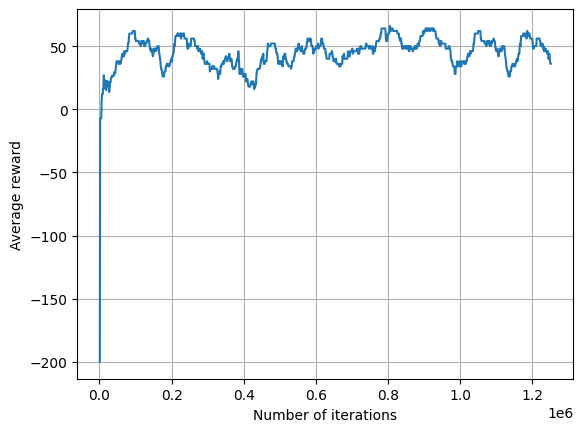

In [72]:
# Plot the average reward
plt.plot(1000*(np.arange(len(average_rewards_vanilla_dqn))+1),average_rewards_vanilla_dqn)
# plt.title('Average reward over the past 100 simulations')
plt.xlabel('Number of iterations')
plt.ylabel('Average reward')
plt.grid()

### Exploring action convergence

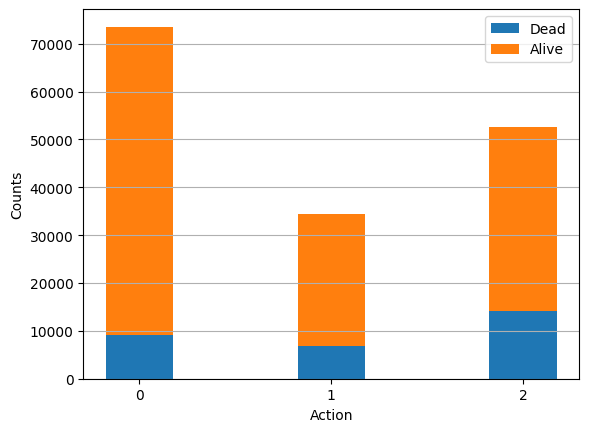

In [71]:
result = data.groupby('action')['dead_30days'].value_counts().unstack()

# Plotting the paired histogram
width = 0.35  # width of the bars

fig, ax = plt.subplots()
categories = result.index
true_counts = result[True]
false_counts = result[False]

bar1 = ax.bar(categories, true_counts, width, label='Dead')
bar2 = ax.bar(categories, false_counts, width, bottom=true_counts, label='Alive')

# Add labels, title, and legend
ax.set_xlabel('Action')
plt.xticks(ticks=range(NUM_BINS))
ax.set_ylabel('Counts')
ax.grid(axis='y')
ax.legend()

# Show the plot
plt.show()